<a href="https://colab.research.google.com/github/karankishinani/Emotion-detection-from-text-using-PyTorch-and-Federated-Learning/blob/master/Emotion_detection_from_text_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion detection from text using PyTorch and Federated Learning

For this project, we are going to implement an NLP task of creating a model to detect the emotion from text. We will develop this using the PyTorch library and the Federated Learning framework for decentralized training.

We will create an emotion detection for the following 5 emotions:

| Emotion | Emoji   | Label   |
|------|------|------|
|Loving| ❤️| 0|
|Playful| ⚽️| 1|
|Happy| 😄| 2|
|Annoyed| 😞| 3|
|Foodie| 🍽| 4|

## Dataset

We will work with a dataset (X, Y) where we have:
*   X contains 132 sentences
*   Y contains a label between [0, 4] corresponding to the five emotions.

For example:

| Sentence | Emotion   |
|----------|-----------|
|food is life|  🍽 Foodie|
|I love you mum|  ❤️ Loving|
|Stop saying bullshit|  😞 Annoyed|
|congratulations on your acceptance|  😄 Happy|
|The assignment is too long|    😞 Annoyed|
|I want to go play| ⚽️ Playful|
|she did not answer my text| 😞 Annoyed|
|Your stupidity has no limit| 😞 Annoyed|
|how many points did he score|  ⚽️ Playful|
|my algorithm performs poorly| 😞 Annoyed|
|I got approved|  😄 Happy|

## The Model
We will build an LSTM model that takes as input word sequences that will take word ordering into account. We will use 50-dimensional [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings to represent words. We will then feed those as an input into an LSTM that will predict the most appropiate emotion for the text.

![alt text](https://drive.google.com/uc?id=1s-KYhU5JWF-jvAlZ2MIKKugxLLDdhpQP)


In [ ]:
!pip install SpeechRecognition

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import random
from moviepy.editor import *
# from pydub import AudioSegment
# from pydub.utils import which
import speech_recognition as sr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/FLASH MDP /audio code/glove.6B.50d.txt'
# nltk.download('stopwords')
# nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def remove_articles(text):
    articles = {'the', 'a', 'an'}
    words = text.split()
    words_filtered = [word for word in words if word not in articles]
    return ' '.join(words_filtered)


def clean_text(t):
    for c in string.punctuation:
        t = t.replace(c, " ")
    t = t.lower()
#     t = remove_articles(t)
    t = t.split()
    wordsFiltered = []
    stops = set(stopwords.words('english'))
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    for w in t:
        if w not in stops:
            wordsFiltered.append(lemmatizer.lemmatize(w))
    return ' '.join(wordsFiltered)



def augment_sentence(sentence):
    words = sentence.split()
    if len(words) > 1:
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)


In [ ]:
# HELPER FUNCTIONS

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [ ]:
X_train, Y_train = read_csv('/content/drive/MyDrive/FLASH MDP /audio code/train_reduced.csv')
X_test, Y_test = read_csv('/content/drive/MyDrive/FLASH MDP /audio code/test (3).csv')

# X_valid, Y_valid = read_csv("valid_binary.csv")

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 2)
Y_oh_test = convert_to_one_hot(Y_test, C = 2)

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(filepath)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def sentences_to_indices(X, word_to_index, max_len, clean_text_function, augment=False):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """

    m = X.shape[0]  # number of training examples
    X_indices = np.zeros((m, max_len))

    for i in range(m):
        # Clean and optionally augment the sentence
        sentence = clean_text_function(X[i])
        if augment:
            sentence = augment_sentence(sentence)

        sentence_words = sentence.lower().split()

        j = 0
        for w in sentence_words:
            if w not in word_to_index or j >= max_len:
                continue
            X_indices[i, j] = word_to_index[w]
            j += 1

    return X_indices


In [ ]:
# X1 = np.array(["lol", "I love you", "this is very yummy"])
# X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
# print("X1 =", X1)
# print("X1_indices =", X1_indices)

## Defining the Network using Pretrained Embedding Layer using GloVe Word Embeddings

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



## Creating the Glove Embedding Layer

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True):
    num_embeddings = len(word_to_index) + 1
    embedding_dim = word_to_vec_map["minicamps"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (num_embeddings, embedding_dim)
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim


## Training the model

In [ ]:
import torch.utils.data
import string

nltk.download('omw-1.4')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen, clean_text, augment=True)

Y_train_oh = convert_to_one_hot(Y_train, C = 2)
# X_valid_indices = sentences_to_indices(X_valid, word_to_index, maxLen, clean_text)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen, clean_text)

# Y_valid_oh = convert_to_one_hot(Y_valid, C = 2)



Y_test_oh = convert_to_one_hot(Y_test, C = 2)

# embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

hidden_dim=128
output_size=2
batch_size = 32

# #print ('Embedding layer is ', embedding)
# #print ('Embedding layer weights ', embedding.weight.shape)b

# model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# epochs = 50
# train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_indices).type(torch.LongTensor), torch.tensor(Y_train).type(torch.LongTensor))
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# train(model, train_loader, test_loader, criterion, optimizer, epochs)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def calculate_accuracy(outputs, labels):
    # 获得每个输出的最大值的索引，这是预测的类别
    _, predicted = torch.max(outputs, 1)
    # 计算正确预测的数量

    # 计算准确率
    corrects = torch.sum(predicted == labels).item()
    return corrects

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(self.hidden_dim, 1)

    def forward(self, lstm_output):
        attn_weights = F.softmax(self.attn(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context, attn_weights

class EnhancedLSTM(nn.Module):
    def __init__(self, embedding, hidden_dim, output_dim, batch_size):
        super(EnhancedLSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.word_embeddings = embedding
        self.bidirectional_lstm = nn.LSTM(
            embedding.embedding_dim,
            hidden_dim,
            num_layers=2,
            dropout=0.5,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.attention = Attention(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.bidirectional_lstm(embeds)
        lstm_out = self.dropout(lstm_out)
        lstm_out, attn_weights = self.attention(lstm_out)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out, attn_weights

# Instantiate the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)
embedding.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLSTM(embedding, hidden_dim=128, output_dim=2, batch_size=64)


model.to(device)


EnhancedLSTM(
  (word_embeddings): Embedding(400001, 50)
  (bidirectional_lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): Attention(
    (attn): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

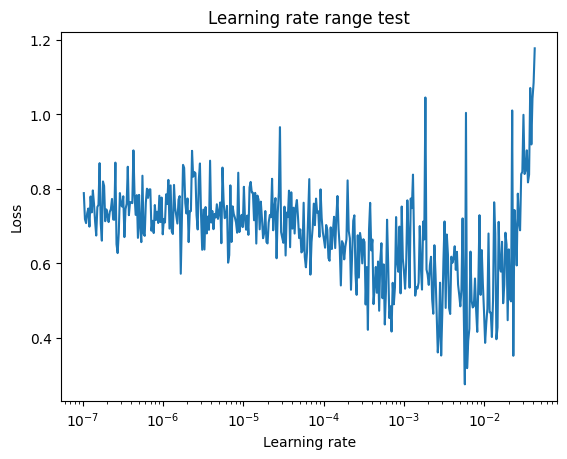

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
criterion = nn.CrossEntropyLoss()
train_dataset = TensorDataset(torch.tensor(X_train_indices).long(), torch.tensor(Y_train).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Starting and ending learning rate for the test
start_lr = 1e-7
end_lr = 1
num_iter = len(train_loader)  # Total number of batches

# Set up the optimizer with the starting learning rate
optimizer = optim.Adam(model.parameters(), lr=start_lr)

lr_lambda = lambda x: np.exp(x * np.log(end_lr / start_lr) / (num_iter - 1))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
current_lr = optimizer.param_groups[0]['lr']
assert current_lr <= end_lr, "Learning rate exceeded end_lr"

# Store the losses and learning rates
losses = []
lrs = []

# Training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)
model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data, target = data.to(device), target.to(device)
    # Get the model's predictions (ignoring the attention weights)
    output, _ = model(data)  # Unpack the tuple returned by your model

    # Calculate the loss using only the output
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Record the loss and the current learning rate
    losses.append(loss.item())
    lrs.append(optimizer.param_groups[0]['lr'])

    # Stop if the loss explodes
    if batch_idx > 0 and losses[-1] > 4 * min(losses):
        break

# Plotting the learning rate range test
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Learning rate range test')
plt.show()


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained embeddings using your predefined function
embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)
embedding.to(device)

# Define your dataset and dataloader
train_dataset = TensorDataset(torch.tensor(X_train_indices).long(), torch.tensor(Y_train).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# valid_dataset = TensorDataset(torch.tensor(X_valid_indices).long(), torch.tensor(Y_valid).long())
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_test_indices).long(), torch.tensor(Y_test).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score





# Initialize your model
output_dim = 2

model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)

# Training loop
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Since the assistant environment doesn't have PyTorch installed, I'll write the code
# without executing it, and the user can execute it in their own environment.

import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def train_k_fold(model_class, full_dataset, criterion, optimizer, num_epochs=10, k=10, clip_value=1.0):
    kf = KFold(n_splits=k, shuffle=True)
    fold_results = {}
    overall_best_auroc_score = 0.0
    overall_best_model_state = None
    avg_train_accs = [0.0] * num_epochs
    avg_val_accs = [0.0] * num_epochs
    train_losses_all_folds = []
    val_losses_all_folds = []
    patience = 10
    best_index = -1
    epoch_num = [num_epochs] * 5
    all_folds_train_acc = []
    all_folds_val_acc = []
    max_epoch_count = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
        print(f'Fold {fold + 1}/{k}')
        # 重置最佳分数和模型状态
        model = EnhancedLSTM(embedding, hidden_dim=64, output_dim=2, batch_size=64)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.00003)
        best_auroc_score = 0.0
        best_val_loss = float('inf')
        best_model_state = None

        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=val_subsampler)

        train_losses = []
        val_losses = []
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        #early stopping
        epochs_no_improve = 0
        early_stop = False

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for sentences, labels in train_loader:
                sentences, labels = sentences.to(device), labels.to(device)
                optimizer.zero_grad()
                output, _ = model(sentences)
                loss = criterion(output, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()

                train_loss += loss.item()
                train_correct += calculate_accuracy(output, labels)
                train_total += labels.size(0)

            train_losses.append(train_loss / len(train_loader))
            # epoch_train_acc = total_correct / total_samples
            # avg_train_accs[epoch] += epoch_train_acc
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            all_val_targets, all_val_outputs = [], []

            train_accs.append(train_correct / train_total)

            val_y_probs, val_y_trues = [], []
            total_correct_val = 0
            total_samples_val = 0


            with torch.no_grad():
                for sentences, labels in val_loader:
                    sentences, labels = sentences.to(device), labels.to(device)
                    output, _ = model(sentences)
                    loss = criterion(output, labels)
                    val_loss += loss.item()

                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    val_y_probs.extend(probabilities[:, 1].cpu().numpy())
                    val_y_trues.extend(labels.cpu().numpy())

                    total_correct_val += calculate_accuracy(output, labels)
                    total_samples_val += labels.size(0)

            val_losses.append(val_loss / len(val_loader))
            epoch_val_acc = total_correct_val / total_samples_val
            avg_val_accs[epoch] += epoch_val_acc
            val_auroc = roc_auc_score(val_y_trues, val_y_probs)
            val_accs.append(total_correct_val / total_samples_val)
            all_folds_train_acc.append(train_accs)
            all_folds_val_acc.append(val_accs)

            if len(train_accs) > max_epoch_count:
              max_epoch_count = len(train_accs)


            if val_auroc > best_auroc_score or (val_auroc == best_auroc_score and val_loss / len(val_loader) < best_val_loss):
                best_auroc_score = val_auroc
                best_val_loss = val_loss / len(val_loader)
                best_model_state = copy.deepcopy(model.state_dict())

            #early stopping
            if val_loss / len(val_loader) <= best_val_loss:
                best_auroc_score = val_auroc
                best_val_loss = val_loss / len(val_loader)
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0  # 重置早停计数器
            else:
                epochs_no_improve += 1  # 增加早停计数器

                if epochs_no_improve >= patience:
                    early_stop = True
                    epoch_num[fold] = epoch
                    print(f"Early stopping triggered after {patience} epochs without improvement.")
                    break

        for fold in range(k):
              all_folds_train_acc[fold] += [all_folds_train_acc[fold][-1]] * (max_epoch_count - len(all_folds_train_acc[fold]))
              all_folds_val_acc[fold] += [all_folds_val_acc[fold][-1]] * (max_epoch_count - len(all_folds_val_acc[fold]))

        avg_train_acc = [np.mean([fold_acc[i] for fold_acc in all_folds_train_acc]) for i in range(max_epoch_count)]
        avg_val_acc = [np.mean([fold_acc[i] for fold_acc in all_folds_val_acc]) for i in range(max_epoch_count)]

        fold_results[fold] = {'best_auroc': best_auroc_score, 'best_loss': best_val_loss}
        train_losses_all_folds.append(train_losses)
        val_losses_all_folds.append(val_losses)

        if best_auroc_score > overall_best_auroc_score:
            overall_best_auroc_score = best_auroc_score
            overall_best_model_state = best_model_state
            best_index = fold

        print(f'Fold {fold + 1} finished. Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Best AUROC: {best_auroc_score}')

    if overall_best_model_state:
        torch.save(overall_best_model_state, 'overall_best_model.pth')
        print(f'Saved overall best model with AUROC: {overall_best_auroc_score}')


    best_fold_train_losses = train_losses_all_folds[best_index]
    best_fold_val_losses = val_losses_all_folds[best_index]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(avg_train_acc, label='Average Training Accuracy')
    plt.title('Average Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(avg_val_acc, label='Average Validation Accuracy')
    plt.title('Average Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    # 画图展示
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(best_fold_train_losses)), best_fold_train_losses, label=f'Fold {best_index+1} Training Loss')
    plt.title(f'Fold {best_index+1} Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(best_fold_val_losses)), best_fold_val_losses, label=f'Fold {best_index+1} Validation Loss')
    plt.title(f'Fold {best_index+1} Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 6))

    for i, train_losses in enumerate(train_losses_all_folds):
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label=f'Fold {i+1}')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    for i, val_losses in enumerate(val_losses_all_folds):
        plt.subplot(1, 2, 2)
        plt.plot(val_losses, label=f'Fold {i+1}')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return fold_results, overall_best_auroc_score




train_k_fold(model, train_dataset, criterion, optimizer, num_epochs=100, k=5, clip_value=1.0)


Fold 1/5


In [ ]:
model_path = 'overall_best_model.pth'

# Assuming you have the embedding layer ready from your training
embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

# Create an instance of the model
model1 = EnhancedLSTM(embedding, hidden_dim=64, output_dim=2, batch_size=64)
model1.to(device)
# Load the saved state dictionary
model1.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# Set the model to evaluation mode
model1.eval()

# Assuming test_loader is defined and is a DataLoader instance for your test dataset
test_y_probs, test_y_trues = [], []
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences = sentences.to(device)
        labels = labels.to(device)
        outputs, _ = model1(sentences)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        test_y_probs.extend(probabilities[:, 1].cpu().numpy())  # Assuming class "1" is the positive class
        test_y_trues.extend(labels.cpu().numpy())

# Calculate the test accuracy and AUROC
test_accuracy = np.mean((np.array(test_y_probs) >= 0.5).astype(int) == np.array(test_y_trues))
test_auroc = roc_auc_score(test_y_trues, test_y_probs)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUROC: {test_auroc}')



Test Accuracy: 0.8669334667333667
Test AUROC: 0.9337832937099568


In [ ]:

list1 = []
string1 = "wow this is awesome wow I love parking"
list1.append(string1)
X = np.array(list1)

string_index = sentences_to_indices(X, word_to_index, maxLen, clean_text)
string_index_tensor = torch.tensor(string_index, dtype=torch.long)  # Convert to LongTensor
output = model1(string_index_tensor)
torch.nn.functional.softmax(output, dim=1)

RuntimeError: ignored